In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
x_train = pd.read_csv(
  "../data/processed/x_train.csv", index_col=0, dtype=str
).reset_index(drop=True)
x_test = pd.read_csv(
  "../data/processed/x_test.csv", index_col=0, dtype=str
).reset_index(drop=True)
y_train = pd.read_csv(
  "../data/processed/y_train.csv", index_col=0, dtype=float
).squeeze("columns").reset_index(drop=True)
y_test = pd.read_csv(
  "../data/processed/y_test.csv", index_col=0, dtype=float
).squeeze("columns").reset_index(drop=True)

In [4]:
# Proper type conversion
def get_correct_types_x(df, numeric_cols):
    for col in ['deenergize_time', 'restoration_time']:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
    return df
numeric_cols = [
    'hftd_tier', 'total_affected', 'residential_affected',
    'longitude', 'latitude', 'total_pop', 'median_age', 'median_income',
    'white_pct', 'tmin_d-5', 'tmax_d-5', 'wspd_d-5', 'tmin_d-4', 'tmax_d-4',
    'wspd_d-4', 'tmin_d-3', 'tmax_d-3', 'wspd_d-3', 'tmin_d-2', 'tmax_d-2',
    'wspd_d-2', 'tmin_d-1', 'tmax_d-1', 'wspd_d-1', 'day_in_year'
]
x_train = get_correct_types_x(x_train, numeric_cols)
x_test = get_correct_types_x(x_test, numeric_cols)
rel_x_train = x_train[numeric_cols]
rel_x_test = x_test[numeric_cols]

In [5]:
# Zero mean, variance 1
scaler = StandardScaler()
scaler.fit(rel_x_train)
scaled_train_x = scaler.transform(rel_x_train)
scaled_test_x = scaler.transform(rel_x_test)

In [6]:
# Read in RF predictions and calculate residuals as observed - predicted
best_preds = np.loadtxt("../data/predictions/rf_preds.csv")
resids = y_test - best_preds

In [7]:
# Take 10% most incorrect predictions
top10_pct_off = np.argsort(
  np.abs(np.array(resids))
)[-int(0.1 * len(resids))::][::-1]
extreme_resids = resids[top10_pct_off]
extreme_x = x_test.iloc[top10_pct_off, :]
extreme_y = y_test[top10_pct_off]

In [8]:
# Fraction of "extreme" errors from a given date vs. fraction for all
print('Fraction of observations in ')
print(
  pd.merge(
    (
      extreme_x.deenergize_time.dt.date.value_counts() /
      extreme_x.deenergize_time.dt.date.value_counts().sum()
    ),
    (
      x_test.deenergize_time.dt.date.value_counts() / 
      x_test.deenergize_time.dt.date.value_counts().sum()
    ),
    how='inner', left_index=True, right_index=True
  ).rename(
    columns={'deenergize_time_x': 'extreme', 'deenergize_time_y': 'all'}
  ).sort_values('extreme', ascending=False)
)

Fraction of observations in 
             extreme       all
2019-10-26  0.564103  0.305344
2019-10-09  0.179487  0.188295
2021-01-19  0.051282  0.007634
2019-10-27  0.051282  0.012723
2020-10-25  0.051282  0.162850
2020-09-07  0.025641  0.022901
2020-09-08  0.025641  0.020356
2021-08-17  0.025641  0.061069
2020-10-26  0.025641  0.002545


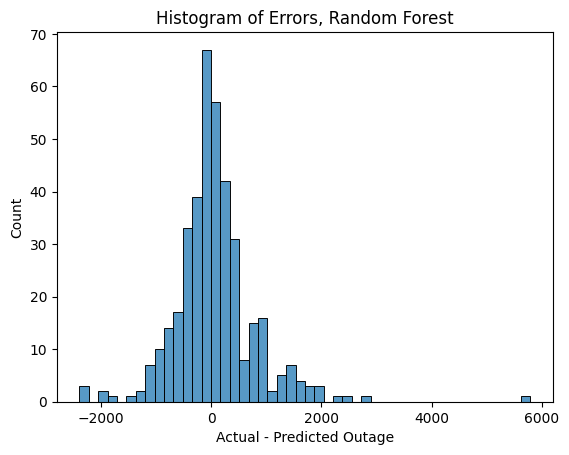

In [13]:
sns.histplot(resids)
plt.title("Histogram of Errors, Random Forest")
plt.xlabel("Actual - Predicted Outage")
plt.savefig("../data/predictions/rf_errors.png")
plt.show()

In [10]:
# Extremely incorrect point (residual around 6K)
print("Most extreme residual")
print(x_test.iloc[np.argmax(np.abs(resids)), :])

Most extreme residual
circuit_name                      WYANDOTTE
deenergize_time         2020-09-07 22:20:00
restoration_time        2020-09-13 08:52:00
key_communities                    OROVILLE
hftd_tier                               3.0
total_affected                        945.0
residential_affected                  885.0
zip_code                              95966
longitude                       -121.540947
latitude                            39.4917
substn_present                         True
total_pop                           29444.0
median_age                             45.2
median_income                       48228.0
white_pct                           0.77194
tmin_d-5                                9.1
tmax_d-5                               30.0
wspd_d-5                                4.0
tmin_d-4                                6.8
tmax_d-4                               20.0
wspd_d-4                                2.8
tmin_d-3                                7.7
tmax_d-3  

In [11]:
def compare_extreme_vals(all, idx, function):
  """
  Compare the extreme values (by index) against all others for a given function
  """
  flip_idx = np.ones(len(all), dtype=bool)
  flip_idx[idx] = False
  extreme = all[idx]
  others = all[flip_idx]
  if all.dtype == float:
    return np.round(function(extreme), 4), np.round(function(others), 4)
  elif all.dtype == '<M8[ns]':
    combined_counts = pd.merge(
      (extreme.dt.date.value_counts() / extreme.dt.date.value_counts().sum()),
      (others.dt.date.value_counts() / others.dt.date.value_counts().sum()),
      how='inner', left_index=True, right_index=True
    )
    combined_counts.columns = ['extreme', 'others']
    return combined_counts.sort_values('extreme', ascending=False)
  elif all.dtype == 'O':
    combined_counts = pd.merge(
      (extreme.value_counts() / extreme.value_counts().sum()),
      (others.value_counts() / others.value_counts().sum()),
      how='inner', left_index=True, right_index=True
    )
    combined_counts.columns = ['extreme', 'others']
    return combined_counts.sort_values('extreme', ascending=False)

In [12]:
# Print Numeric Features
numeric_diffs = pd.DataFrame(
  [(feat, compare_extreme_vals(x_test[feat], top10_pct_off, np.median))
   for feat in x_test.columns if x_test[feat].dtype == float],
  columns=['feature', 'medians']
)
# Extract medians for extreme vs less extreme residuals
numeric_diffs['extreme'] = [feat[0] for feat in numeric_diffs.medians]
numeric_diffs['others'] = [feat[1] for feat in numeric_diffs.medians]
numeric_diffs['pct_diff'] = (
  (numeric_diffs.extreme - numeric_diffs.others) / numeric_diffs.others
)
numeric_diffs['abs_diff'] = np.abs(numeric_diffs.pct_diff)
# Get percent differences to see patterns in incorrect responses
print('\nDifference in medians between extreme and other residuals')
print('-----------------------------------------------------------')
print(
  numeric_diffs.sort_values('abs_diff', ascending=False).\
    drop(columns=['medians', 'abs_diff']).reset_index(drop=True)
)


Difference in medians between extreme and other residuals
-----------------------------------------------------------
                 feature     extreme      others  pct_diff
0               wspd_d-2      9.4000      7.1500  0.314685
1              total_pop  14970.0000  20681.0000 -0.276147
2               wspd_d-1      5.1000      6.9000 -0.260870
3               tmin_d-2     13.3000     10.6000  0.254717
4               wspd_d-4      6.0000      7.0000 -0.142857
5         total_affected    733.0000    835.5000 -0.122681
6          median_income  74324.0000  68477.0000  0.085386
7   residential_affected    650.0000    706.0000 -0.079320
8               wspd_d-3      7.6000      7.0500  0.078014
9               tmax_d-5     29.0000     27.2000  0.066176
10              tmax_d-3     30.0000     28.3000  0.060071
11              tmin_d-4      9.4000     10.0000 -0.060000
12              tmin_d-5      8.9000      9.4000 -0.053191
13              tmin_d-1      8.9000      9.4000 -0.053